In [42]:
#importing libraries
import pandas as pd
import json
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
from itertools import combinations

In [43]:
""" 
Description: Model that conducts resource allocation (Crashing)
Assignment:  A2 - Resource Constraining and Resource Allocation

Author: Mehulkumar Jariwala and Akshaykumar Dhorajiya

Due Date: 8th November,2022

Language: python

To Compile: In the command line, please run the following command:

        Q2_Mehul_and_Akshay.ipynb

The above command will run the script and generate the tabular output showcasing the following:
1. Original Project Schedule
2. Gantt-Chart showcasing project schedule when crashing critical activities in order to reduce project duration.
3. Iteratively reducing the project duration and a schedule showcasing each iteration.

Not Addressed: N/A - all requirements of the assignments are addressed

Input: Please note the following:
        1. Change the CSV filepath at "CSV_PATH = "/content/Assignment_2_Q2-5.csv"")" when inserting new CSV files.
        2. Please ensure the new CSV files are in the SAME DIRECTORY.

Output: The following output is shown:
        1. Using matplotlib, a multiple pngs are generated as well as saved in the directory: ./Q2_Plots/
        2. PNGs include:
            - Original Schedule
            - Crash Schedule - All iterations are shown starting from 1
        3. Q2_Mehul and Akshay_iterativelogs.csv - file containing the logs of each crash iteration.
            - Includes the activities crashed, savings, penalties, total_savings, total_penalties, total_project_cost

Algorithm: The following data structures / algorithms were used:
        1. Class Node to store activity information (ES, EF, LS, LF, TF, LF, predecessors, successors, is_critical)
        2. A recursive forward and backward implementation is used to ensure that the formulae to calculate the 
           activity parameters is satisfied.
        3. A DFS Graph algorithm is used to find the critical path(s). It visits all critical nodes from start to end and keeps
           track of all possible paths.
        4. Iterative trial-and-error implementation that crashes all critical activities until project duration is reduced to the maximum.
           - In case of multiple critical paths, the algorithm takes a combination of paths to find minimum_intersection critical node
           that helps crash both the paths.
           - Scenarios with intersection of two or more paths along with an individual paths are considered to determine a critical node.
           - Individual paths are considered too - the node with lowest cost in always considered.
           here we are pointing out few function and it's uses.
           - read_csv(): Input path to the csv file and returns a pandas dataframe.
           - generate_nodes(): From the dataframe, creates a dictionary of nodes and tracks their successors and predecessors and other metrics like ES, EF, LS, LF, TF and FF.
           - set_critical_nodes(): Traverses all the nodes and sets is_critical to “Yes” if the node is critical. Also returns the total number of critical nodes.
           - get_critical_edges(): Only takes the critical nodes into consideration. If their successor(s) is also critical, forms an edge between the current critical node and its critical successor with weight 1.
           - make_graph(): takes the critical edges and total number of critical nodes and forms an adjacency list data structure to represent the graph.
           - get_default_df(): takes in nodes and returns a df containing all the info. This is only called once - during initial activity setup
           - get_interative_df(): takes in modified nodes in the iterative process of crashing activities, and returns a dataframe containing all info.
 
           - save_gantt_chart(): takes in a dataframe and produces a gantt chart used to display project schedule - before and after levelling/crashing.
           - save_histogram(): takes in a dataframe and produces a histogram used to display project resource allocation - before and after levelling.
           """

' \nDescription: Model that conducts resource allocation (Crashing)\nAssignment:  A2 - Resource Constraining and Resource Allocation\n\nAuthor: Mehulkumar Jariwala and Akshaykumar Dhorajiya\n\nDue Date: 8th November,2022\n\nLanguage: python\n\nTo Compile: In the command line, please run the following command:\n\n        Q2_Mehul_and_Akshay.ipynb\n\nThe above command will run the script and generate the tabular output showcasing the following:\n1. Original Project Schedule\n2. Gantt-Chart showcasing project schedule when crashing critical activities in order to reduce project duration.\n3. Iteratively reducing the project duration and a schedule showcasing each iteration.\n\nNot Addressed: N/A - all requirements of the assignments are addressed\n\nInput: Please note the following:\n        1. Change the CSV filepath at "CSV_PATH = "/content/Assignment_2_Q2-5.csv"")" when inserting new CSV files.\n        2. Please ensure the new CSV files are in the SAME DIRECTORY.\n\nOutput: The follow

In [44]:
from __future__ import annotations

# create structure for node
class Node:
    
    def __init__(self,activity,duration):
        self.activity = activity
        self.duration = duration
        self.es = None
        self.ef = None
        self.ls = None
        self.lf = None
        self.tf = None
        self.ff = None
        
        self.previous = []
        self.next = []
        
        self.resources = 0
        self.crash_duration = 0
        self.normal_cost = 0
        self.crash_cost = 0
        
        #keep "NO" as default value
        self.is_critical = "NO"
    
    def __repr__(self) -> str:
        return "{" \
            f"\"Activity\":\"{self.activity}\", " \
            f"\"Duration\":\"{self.duration}\", " \
            f"\"Duration after Crash\":\"{self.crash_duration}\", " \
            f"\"ES\":\"{self.es}\", " \
            f"\"EF\":\"{self.ef}\", " \
            f"\"LS\":\"{self.ls}\", " \
            f"\"LF\":\"{self.lf}\", " \
            f"\"TF\":\"{self.tf}\", " \
            f"\"FF\":\"{self.ff}\", " \
            f"\"previous\":\"{list(map(lambda node: node.activity, self.previous))}\", " \
            f"\"next\":\"{list(map(lambda node: node.activity, self.next))}\", " \
            f"\"Resources\":\"{self.resources}\", " \
            f"\"Normal Cost\":\"{self.normal_cost}\", " \
            f"\"Cost after Crash\":\"{self.crash_cost}\", " \
            f"\"Critical Path\":\"{self.is_critical}\"" \
            "}\n"

In [45]:
# function to generate nodes.
def create_nodes(data):

    # create nodes structure and initialize "start"&"end" nodes as 0
    nodes = dict()
    nodes['Start'] = Node(activity="Start",duration=0)
    nodes['End'] = Node(activity="End",duration=0)
    
    for a in data['Activity']:
        if a not in nodes:
            activity = a
            duration = data[data["Activity"]==a]["Duration"]
            d=duration.values[0] #in order to get exact value of duration
            
            node = Node(activity=activity,duration=d)
            
            
            if "Normal Cost" in data.columns:
                node.normal_cost = data[data["Activity"]==a]["Normal Cost"].values[0]
                #node.normal_cost = row["Normal Cost"]
            if "Cost after Crash" in data.columns:
                node.crash_cost = data[data["Activity"]==a]["Cost after Crash"].values[0]
                #node.crash_cost = row["Cost after Crash"]
            if "Duration after Crash" in data.columns:
                node.crash_duration = data[data["Activity"]==a]["Duration after Crash"].values[0]
                #node.crash_duration = row["Duration after Crash"]
            
            nodes[activity]=node 
            
    # iterate to keeep track of prev. & next node
    for i,row in data.iterrows():
        current = row['Activity'].strip()
        dependents = row['Depends on'].strip().split(",")
        
        for d in dependents:
            d = d.strip()
            if d.isalpha():
                nodes[current].previous.append(nodes[d])
                nodes[d].next.append(nodes[current])

    # connect "start" and "end" nodes
    for node in filter(lambda node:node.activity not in ['Start','End'],nodes.values()):
        if not node.next:
            node.next.append(nodes['End'])
            nodes['End'].previous.append(node)
    
        if not node.previous:
            node.previous.append(nodes['Start'])
            nodes['Start'].next.append(node)

    return nodes

In [46]:
# function for forward traversing
def forward_traverse(end):
    max_es = 0
    node = end
    
    #if predecessor's EF is not defined, go back recursively to find
    #predecessor's EF
    for p in node.previous:
        forward_traverse(end=p)
        max_es = max(max_es, p.ef)
    
    #ES is the max. value of predecessors EF value
    node.es = max_es
    node.ef = node.es + node.duration

In [47]:
# Defining function for backward traversing
def backward_traverse(end):
    min_lf = 7777777777777777777
    min_ff = 7777777777777777777
    
    node = end
    
    #if successor's LS is not defined, go further recursively to find
    #successor's LS
    for s in node.next:
        if s.activity != "End":
            backward_traverse(end=s)
        
        min_lf = min(min_lf,s.ls)
        min_ff = min(min_lf,s.es - node.ef)
        
    #LF is the min. value of successor's LS value.
    node.lf = min_lf
    node.ls = node.lf - node.duration
    
    node.tf = node.ls - node.es
    
    #if node is critical, then set is_critical=true
    if node.es - node.ls == 0:
        node.is_critical = "YES"
    
    node.ff = min_ff

In [48]:
# read csv file and convert it into pandas dataframe
data = pd.read_csv("/content/Assignment_2_Q2-6.csv")
data

,Activity,Duration,Depends on,Duration after Crash,Normal Cost,Cost after Crash
0,A,6,---,4,400,460
1,B,11,---,9,750,780
2,C,16,---,13,800,890
3,D,7,"A, B",5,450,490
4,E,3,B,3,200,200
5,F,10,C,8,600,640
6,G,9,"D, E",8,500,525
7,H,6,"C, E",4,250,300
8,I,5,F,3,350,370
9,J,6,F,3,450,510


In [49]:
inp_value = int(input("What is your Over-head Cost Per Day ?: "))

What is your Over-head Cost Per Day ?: 30


In [50]:
nodes = create_nodes(data)

In [51]:
# create a column with to color the critical path
def color(row):
    c_dict = {'YES':'#E64646', 'NO':'#3475D0'}
    return c_dict[row['Critical Path']]

In [52]:
def get_default_df(value, nodes):
    df = []

    for node in nodes.values():
        node_str = repr(node)
        node_dict = json.loads(node_str)
        df.append(node_dict)
    
    df = pd.DataFrame.from_dict(df)

    # Convert columns to int
    df["Duration after Crash"] = pd.to_numeric(df["Duration after Crash"])
    df["Normal Cost"] = pd.to_numeric(df["Normal Cost"])
    df["Cost after Crash"] = pd.to_numeric(df["Cost after Crash"])
    df["Duration"] = pd.to_numeric(df["Duration"])

    df.drop(columns=["previous", "next"], axis=1, inplace=True)
    df = df[~df["Activity"].isin(["Start", "End"])]
    df['Color'] = df.apply(color, axis=1)


    # If both normal_duration, crash_duration is same - there is no room for crashing
    df["Cost after Crash/Day"] = df.apply(lambda row: 0 if (row["Duration"] - row["Duration after Crash"] == 0) else (row["Cost after Crash"] - row["Normal Cost"]) / (row["Duration"] - row["Duration after Crash"]), axis=1) 

    # Indirect cost = $value * normal_duration
    df["Indirect Cost"] = df.apply(lambda row: value * row["Duration"], axis=1)

    return df

In [53]:
def get_iterative_df(value, nodes):
    df = []

    for node in nodes.values():
        node_str = repr(node)
        node_dict = json.loads(node_str)
        df.append(node_dict)
    
    df = pd.DataFrame.from_dict(df)

    # Convert columns to int
    df["Duration after Crash"] = pd.to_numeric(df["Duration after Crash"])
    df["Normal Cost"] = pd.to_numeric(df["Normal Cost"])
    df["Cost after Crash"] = pd.to_numeric(df["Cost after Crash"])
    df["Duration"] = pd.to_numeric(df["Duration"])

    df.drop(columns=["previous", "next"], axis=1, inplace=True)
    df = df[~df["Activity"].isin(["Start", "End"])]
    df['Color'] = df.apply(color, axis=1)

    # Indirect cost = $value * normal_duration
    df["Indirect Cost"] = df.apply(lambda row: value * row["Duration"], axis=1)

    return df

In [54]:
import json

# defining function to get edges of critical nodes
def obtain_edges(nodes):
    edges = [] #create empty list for storing edges
    
    for node in nodes.values():
        src_dict = json.loads(repr(node))
        
        #check if current node is critical, if not then continue to 
        #explore further nodes, and look for the node which is critical
        if src_dict['Critical Path']=="NO":
            continue
        
        src = src_dict['Activity']
        
        #loop through successors(i.e creating the list of successors)
        successors = src_dict['next'].lstrip("[").rstrip("]").split(", ")

        #check whether the list of successors is empty or not.
        if successors != ['']:
            for s in successors:
                s = s.lstrip("'").rstrip("'")
                dest = json.loads(repr(nodes[s]))
                
                #check whether destination is critical or not, if it is 
                #critical then add it into "edges" list
                if dest["Critical Path"]=="YES":
                    edges.append((src,dest["Activity"]))
                    
    return edges

In [55]:
#defining function to find the paths
def get_path(graph,start,end,path):
    path = path + [start]
    
    if start == end:
        return [path]
    
    if start not in graph:
        return []
    
    paths = []
    
    for node in graph[start]:
        # continue, if node is not discovered
        if node not in path:
            newpaths = get_path(graph, node, end, path)
            for newpath in newpaths:
                paths.append(newpath)
    return paths

In [56]:
def get_nodes_to_crash(paths, df):
    nodes_to_crash = {}
    # Find the node with min(Cost after Crash/day)
    for path in paths:
        path_nodes = {}
        for node in path:
            # Condition: Duration >= Duration after Crash for node to crash
            if node.isalpha() and (nodes[node].duration > nodes[node].crash_duration):
                path_nodes[node] = df.loc[df.Activity == node, 'Cost after Crash/Day'].values
            
        if (path_nodes):
            # Identify the node to crash for given path
            node_to_crash = min(path_nodes, key=path_nodes.get)
            # Crash cost of the identified node
            min_crash_cost = path_nodes[node_to_crash]
            nodes_to_crash[node_to_crash] = min_crash_cost[0]

    return nodes_to_crash

In [57]:
def crash_nodes(nodes, nodes_to_crash, iter_num):

    if (nodes_to_crash is None):
        title = "Q2 Original Schedule"

    else:
        title = f"Q2 - {iter_num} Crash Schedule"
        # From the provided nodes, subtract 1 from activity duration
        for crash_node, crash_cost in nodes_to_crash.items():
            # Update the node duration
            #nodes[crash_node].set_duration(nodes[crash_node].get_duration() - 1)
            nodes[crash_node].duration = nodes[crash_node].duration - 1

    start = nodes["Start"]
    end = nodes["End"]

    # Populate earliest start and finish by recursing until the end node
    forward_traverse(end)


    # Update "end" late start and finish values
    end.ls = end.lf = end.es

    # Populate late start and finish by recursing until the start node
    backward_traverse(start)

    # Check for critical paths
    #N = set_critical_nodes(nodes)
    count = 0
    #if node is critical, then set is_critical = "Yes"
    for node in nodes.values():
        if node.es - node.ls==0:
            node.is_critical = "YES"
            node.tf = 0
            count = count + 1
        else:
            node.tf = node.ls - node.es
    total_critical = count #assign count to variable called "total_critical"

    proj_start = int(json.loads(repr(nodes["Start"]))["ES"])
    proj_end = int(json.loads(repr(nodes["End"]))["EF"])
    

    # Prepare Database for Gantt-Chart/Histogram
    if (nodes_to_crash is None):
        default_df = get_default_df(inp_value, nodes)
        #save_gantt_chart(default_df, title, proj_start, proj_end, "Duration (Days)", "Activities")
        _, ax = plt.subplots(figsize=(18,7))

        # Plot Legends
        plt.grid()
        c_dict = {'Critical':'#A40606', 'Non-Critical':'#20BF55'}
        legend_elements = [Patch(facecolor=c_dict[i], label=i)  for i in c_dict]
        plt.legend(handles=legend_elements)

        # Plot Ticks
        xticks = np.arange(0, proj_end+2, 1)
        xticks_labels = np.arange(proj_start, proj_end+2)

        ax.set_xticks(xticks)
        ax.set_xticklabels(xticks_labels[::1])

        # Gantt Chart
        ax.barh(default_df.Activity, pd.to_numeric(default_df.Duration), left=pd.to_numeric(default_df.ES), color=default_df.Color)
        plt.title(title)
        plt.xlabel("Duration (days)")
        plt.ylabel("Activity")
        plt.gca().invert_yaxis()

        # Clear the current figure
        plt.show()
    else:
        df = get_iterative_df(inp_value, nodes)
        #save_gantt_chart(df, title, proj_start, proj_end, "Duration (Days)", "Activities")
        _, ax = plt.subplots(figsize=(18,7))

        # Plot Legends
        plt.grid()
        c_dict = {'Critical':'#A40606', 'Non-Critical':'#20BF55'}
        legend_elements = [Patch(facecolor=c_dict[i], label=i)  for i in c_dict]
        plt.legend(handles=legend_elements)

        # Plot Ticks
        xticks = np.arange(0, proj_end+2, 1)
        xticks_labels = np.arange(proj_start, proj_end+2)

        ax.set_xticks(xticks)
        ax.set_xticklabels(xticks_labels[::1])

        # Gantt Chart
        ax.barh(df.Activity, pd.to_numeric(df.Duration), left=pd.to_numeric(df.ES), color=df.Color)
        plt.title(title)
        plt.xlabel("Duration (days)")
        plt.ylabel("Activity")
        plt.gca().invert_yaxis()


        # Clear the current figure
        plt.show()
    
    # Graph edges - only critical nodes
    edges = obtain_edges(nodes)

    #graph = make_graph(edges, N)
    adjacency = dict()

    for (s,d) in edges:
        if s not in adjacency:
            adjacency[s] = {d:1}
        else:
            adjacency[s][d] = 1
            
    #add "End" node
    adjacency["End"] = {}

    graph = adjacency
    
    # List to store the complete path between source and destination
    paths = get_path(graph, "Start", "End", [])

    path_str = "\n".join(map(lambda path: " -> ".join(path), paths))
    path_str = path_str.replace("Start -> ", "")
    path_str = path_str.replace(" -> End", "")
    paths = path_str.split("\n")
    num_paths = len(paths)

    if (nodes_to_crash is None):
        return {
            "df": default_df,
            "paths": paths,
            "num_paths": num_paths,
        }
    else:
        return {
            "df": df,
            "paths": paths,
            "num_paths": num_paths,
            "proj_duration": proj_end
        }

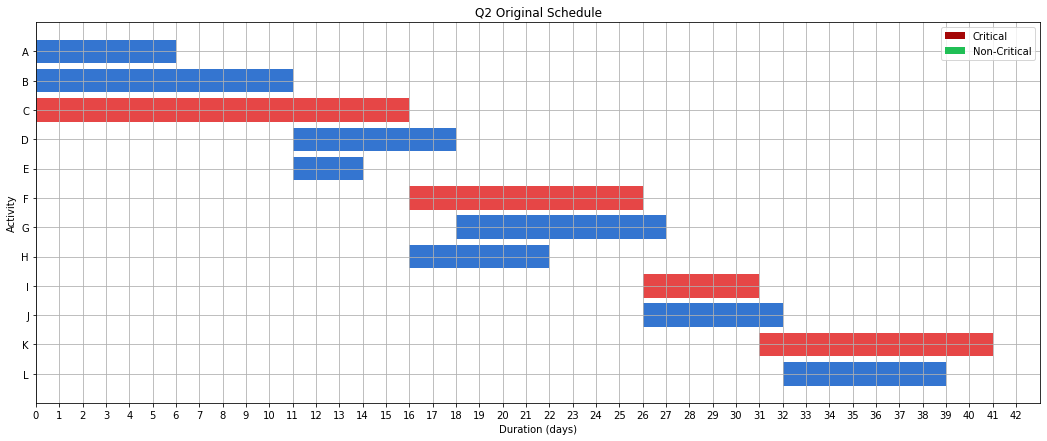

In [58]:
retval = crash_nodes(nodes, None, 0)
num_paths = retval["num_paths"]
paths = retval["paths"]
# paths = 
default_df = retval["df"]

In [59]:
# Initial costs at project beginning
direct_cost = default_df["Normal Cost"].sum()
project_duration = int(json.loads(repr(nodes["End"]))["EF"])
indirect_cost = inp_value * project_duration

iterative_proj_duration = project_duration

In [60]:
print('\033[1m'+'-------------- Initial Project Costs --------------'+'\033[0m'+'\n')
total_project_cost = direct_cost + indirect_cost
print('\033[1m'+'Direct Cost: '+'\033[0m', direct_cost)
print('\033[1m'+'Indirect Cost: '+'\033[0m', indirect_cost)
print('\033[1m'+"Total Project Cost: "+'\033[0m', total_project_cost)

-------------- Initial Project Costs --------------

Direct Cost:  5600
Indirect Cost:  1230
Total Project Cost:  6830


In [61]:
iter_num = 1
min_project_cost = 7777777777777777777

cumulative_penalty = 0
cumulative_savings = 0

cumulative_lst = []

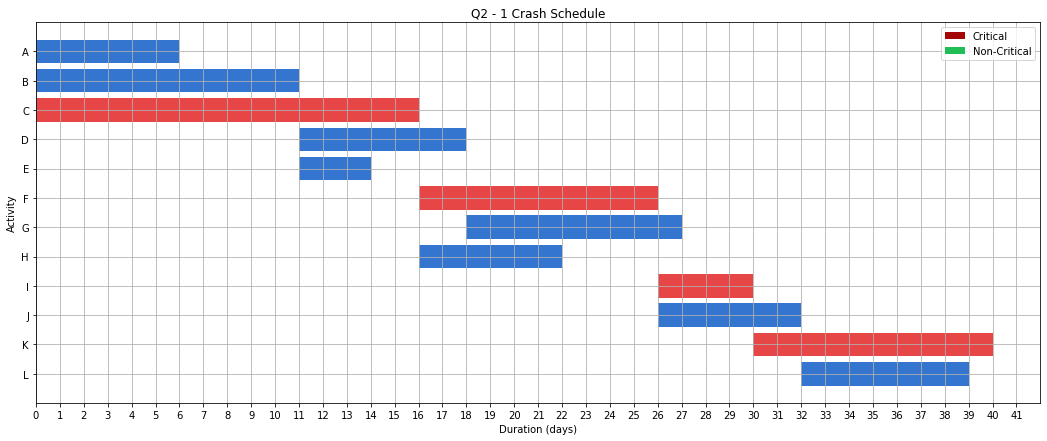

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


----------------------------------------------------

{'Iteration': 1, 'Activity(ies) Crashed': 'I', 'Penalty': 10.0, 'Cumulative Penalty': 10.0, 'Savings': 30, 'Cumulative Savings': 30, 'Total Project Cost': 6830.0}


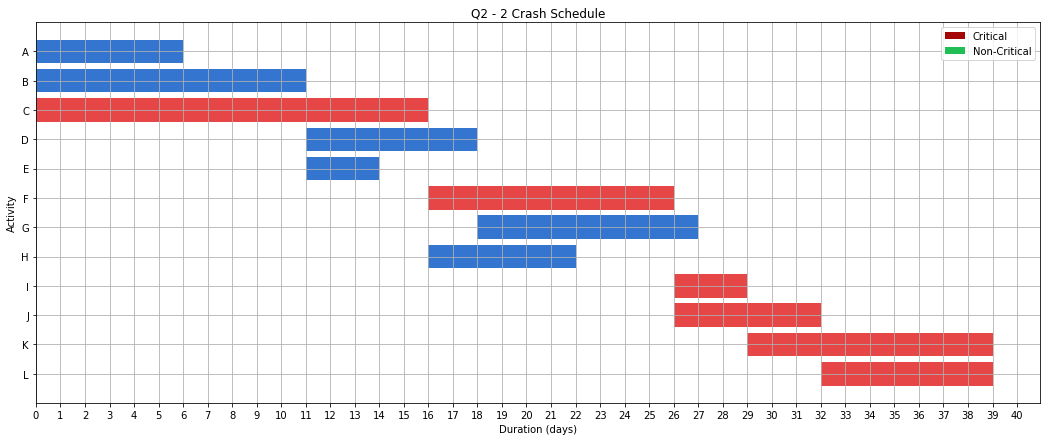

----------------------------------------------------

{'Iteration': 2, 'Activity(ies) Crashed': 'I', 'Penalty': 10.0, 'Cumulative Penalty': 20.0, 'Savings': 30, 'Cumulative Savings': 60, 'Total Project Cost': 6810.0}


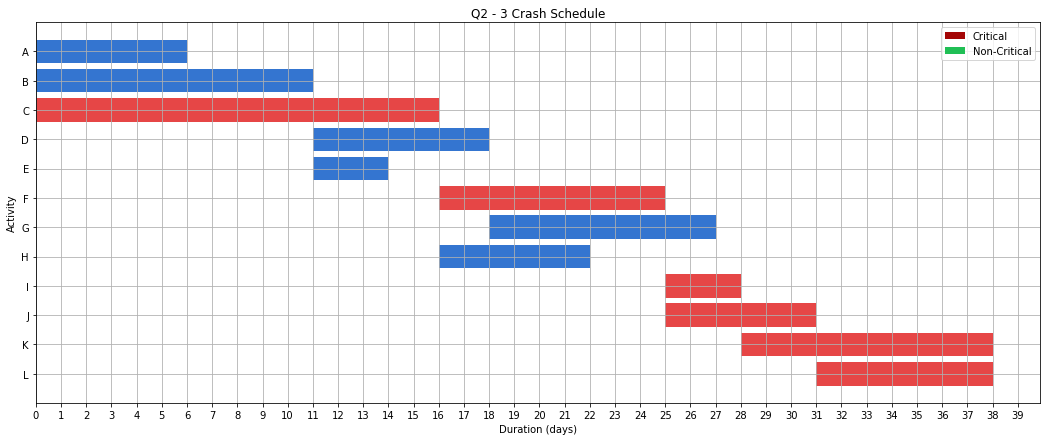

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


----------------------------------------------------

{'Iteration': 3, 'Activity(ies) Crashed': 'F', 'Penalty': 20.0, 'Cumulative Penalty': 40.0, 'Savings': 30, 'Cumulative Savings': 90, 'Total Project Cost': 6790.0}


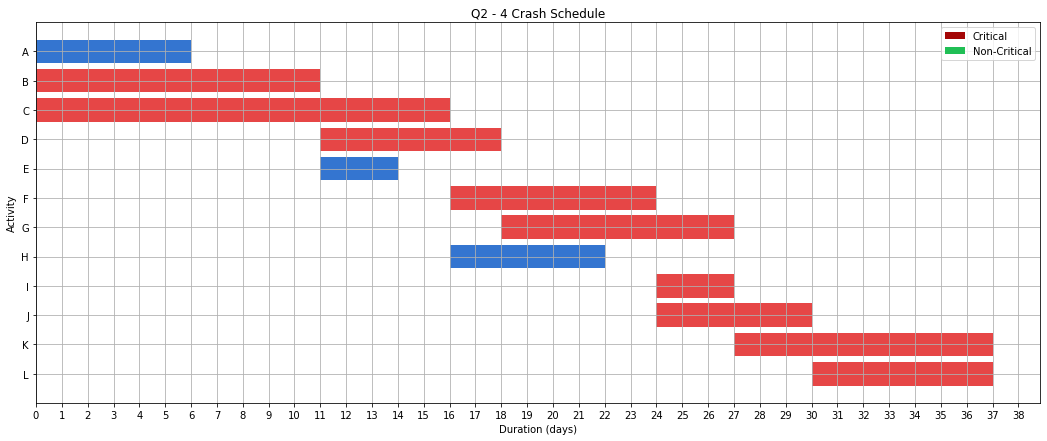

----------------------------------------------------

{'Iteration': 4, 'Activity(ies) Crashed': 'F', 'Penalty': 20.0, 'Cumulative Penalty': 60.0, 'Savings': 30, 'Cumulative Savings': 120, 'Total Project Cost': 6780.0}


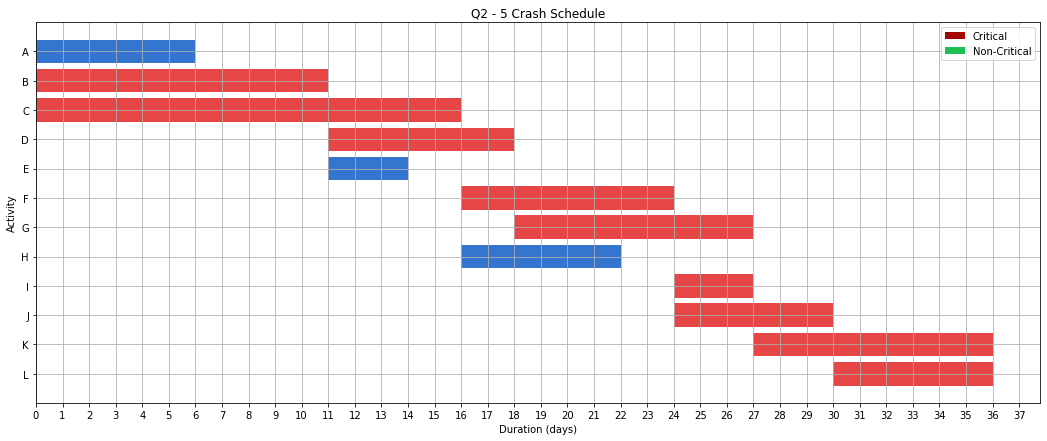

----------------------------------------------------

{'Iteration': 5, 'Activity(ies) Crashed': 'K, L', 'Penalty': 25.0, 'Cumulative Penalty': 85.0, 'Savings': 30, 'Cumulative Savings': 150, 'Total Project Cost': 6770.0}


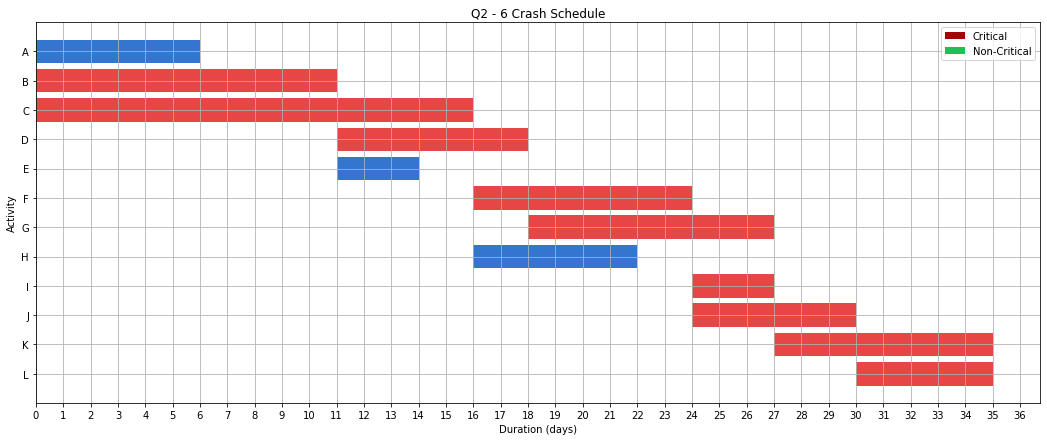

----------------------------------------------------

{'Iteration': 6, 'Activity(ies) Crashed': 'K, L', 'Penalty': 25.0, 'Cumulative Penalty': 110.0, 'Savings': 30, 'Cumulative Savings': 180, 'Total Project Cost': 6765.0}


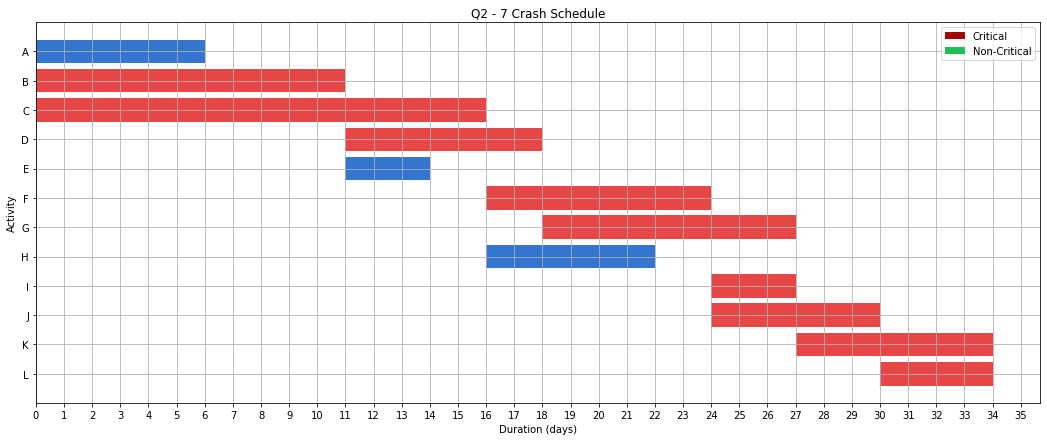

----------------------------------------------------

{'Iteration': 7, 'Activity(ies) Crashed': 'K, L', 'Penalty': 25.0, 'Cumulative Penalty': 135.0, 'Savings': 30, 'Cumulative Savings': 210, 'Total Project Cost': 6760.0}


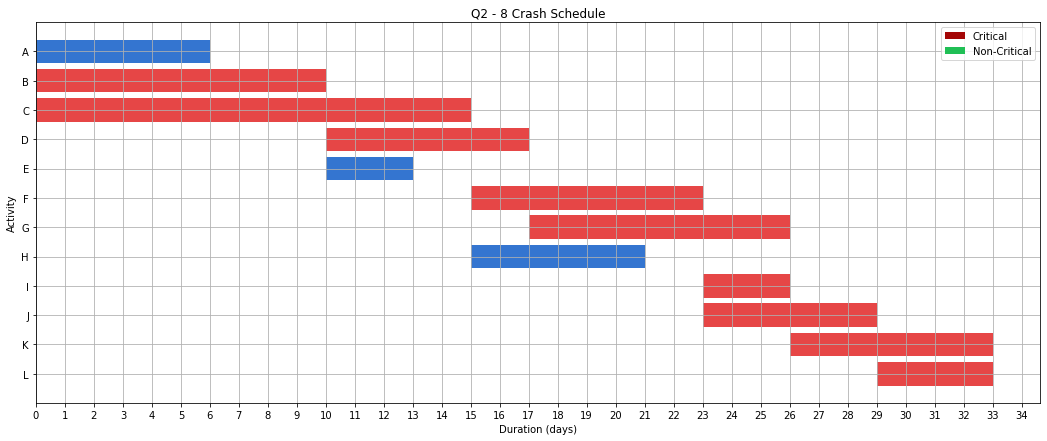

----------------------------------------------------

{'Iteration': 8, 'Activity(ies) Crashed': 'C, B', 'Penalty': 45.0, 'Cumulative Penalty': 180.0, 'Savings': 30, 'Cumulative Savings': 240, 'Total Project Cost': 6755.0}


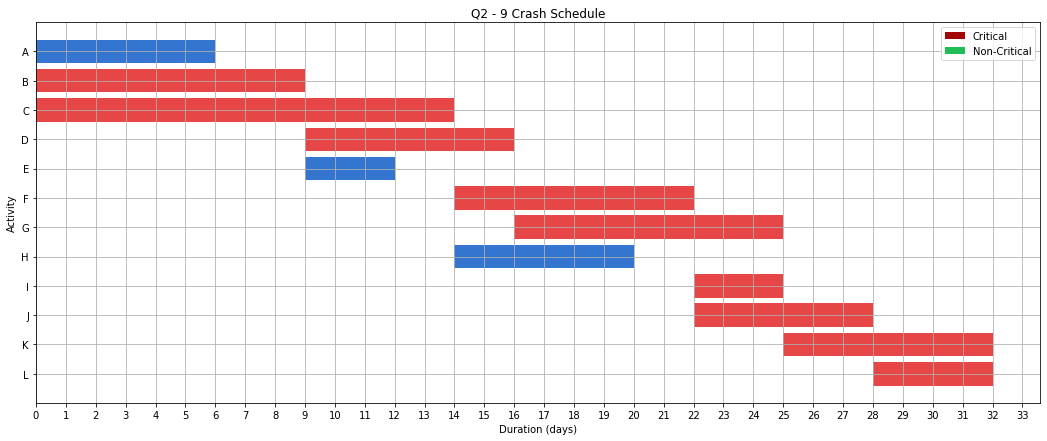

----------------------------------------------------

{'Iteration': 9, 'Activity(ies) Crashed': 'C, B', 'Penalty': 45.0, 'Cumulative Penalty': 225.0, 'Savings': 30, 'Cumulative Savings': 270, 'Total Project Cost': 6770.0}


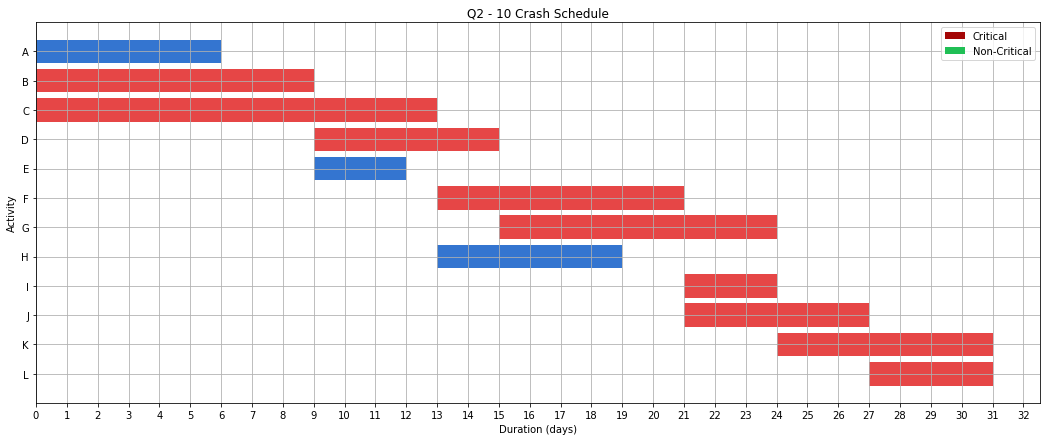

----------------------------------------------------

{'Iteration': 10, 'Activity(ies) Crashed': 'C, D', 'Penalty': 50.0, 'Cumulative Penalty': 275.0, 'Savings': 30, 'Cumulative Savings': 300, 'Total Project Cost': 6785.0}


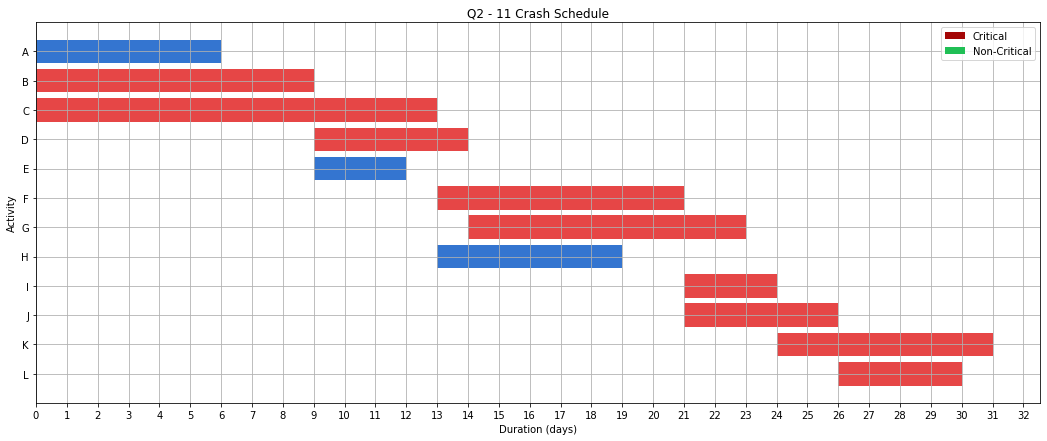

----------------------------------------------------

{'Iteration': 11, 'Activity(ies) Crashed': 'D, J', 'Penalty': 40.0, 'Cumulative Penalty': 315.0, 'Savings': 30, 'Cumulative Savings': 330, 'Total Project Cost': 6805.0}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [62]:
while True:
    
    #check wether critical_path > 1 or not
    if num_paths > 1:
        # Find common nodes - combination of paths
        subsets = list(combinations(paths, 2))
        common_nodes = {}
        node_path = {}
        
        for subset in subsets:
            # Get intersection
            intersecting_nodes = set.intersection(*[set(x) for x in subset])
            
            #If intersecting nodes are present
            if (intersecting_nodes):
                
                for node in intersecting_nodes:
                    if node.isalpha() and (nodes[node].duration > nodes[node].crash_duration):
                        # Common Nodes of a subset
                        common_nodes[node] = default_df.loc[df.Activity == node, 'Cost after Crash/Day'].values
                        node_path[node] = subset
        
        if (common_nodes):
            # if Intersection is present - take minimum
            node_to_crash = min(common_nodes, key=common_nodes.get)
            min_crash_cost = common_nodes[node_to_crash]
            
            nodes_to_crash = {node_to_crash: min_crash_cost[0]}
            
            # Check for remaining paths without intersection
            remaining_nodes = get_nodes_to_crash(paths, default_df)
            
            subset = node_path[node_to_crash]
            for key, value in remaining_nodes.items():
                # Check if remaining node is in the subset
                if (key not in subset[0]) and (key not in subset[1]):
                    nodes_to_crash[key] = value
            
            # Start Crashing
            retval = crash_nodes(nodes, nodes_to_crash, iter_num)
            num_paths = retval["num_paths"]
            paths = retval["paths"]
            df = retval["df"]
            iterative_proj_duration = retval["proj_duration"]

            default_df = default_df.drop('Duration', 1)
            default_df["Duration"] = df["Duration"].copy()
            
            # Add penalty costs
            penalty = sum(nodes_to_crash.values())
            cumulative_penalty += penalty
            total_project_cost += penalty
            
            # Subtract savings
            savings = inp_value
            cumulative_savings += savings
            total_project_cost -= savings
            
            
            activities = nodes_to_crash.keys()
            activity_str = ""
            for activity in activities:
                activity_str += activity + ", "
            
            activity_str = activity_str.rstrip(", ")
            
            cumulative_dict = {
                    "Iteration": iter_num,
                    "Activity(ies) Crashed": activity_str,
                    "Penalty": penalty,
                    "Cumulative Penalty": cumulative_penalty,
                    "Savings": savings,
                    "Cumulative Savings": cumulative_savings,
                    "Total Project Cost": total_project_cost + savings - penalty
            }
            
            print('\033[1m'+"----------------------------------------------------"+'\033[0m'+'\n')
            print(cumulative_dict)
            
            cumulative_lst.append(cumulative_dict)
            
            iter_num += 1
            
            if (project_duration == iterative_proj_duration):
                break
            
            project_duration = iterative_proj_duration
            
        else:
            # No intersection
            nodes_to_crash = get_nodes_to_crash(paths, default_df)
            if (nodes_to_crash):
                # Begin Crashing
                retval = crash_nodes(nodes, nodes_to_crash, iter_num)
                
                # Update Critical Path(s), DataFrame
                num_paths = retval["num_paths"]
                paths = retval["paths"]
                df = retval["df"]
                iterative_proj_duration = retval["proj_duration"]
                default_df = default_df.drop('Duration', 1)
                default_df["Duration"] = df["Duration"].copy()
                
                # Add penalty costs
                penalty = sum(nodes_to_crash.values())
                cumulative_penalty += penalty
                total_project_cost += penalty
                
                # Subtract savings
                savings = inp_value
                cumulative_savings += savings
                total_project_cost -= savings
                
                activities = nodes_to_crash.keys()
                activity_str = ""
                
                for activity in activities:
                    activity_str += activity + ", "
                    
                activity_str = activity_str.rstrip(", ")
                
                cumulative_dict = {
                        "Iteration": iter_num,
                        "Activity(ies) Crashed": activity_str,
                        "Penalty": penalty,
                        "Cumulative Penalty": cumulative_penalty,
                        "Savings": savings,
                        "Cumulative Savings": cumulative_savings,
                        "Total Project Cost": total_project_cost + savings - penalty
                }
                
                print('\033[1m'+"----------------------------------------------------"+'\033[0m'+'\n')
                print(cumulative_dict)
                
                cumulative_lst.append(cumulative_dict)
                iter_num += 1
                
                if (project_duration == iterative_proj_duration):
                    break
                
                project_duration = iterative_proj_duration
                
            else:
                # Break when no further critical nodes can be broken down
                break
                
    else:
        node_to_crash = get_nodes_to_crash(paths, default_df)
        if (node_to_crash):
            
            # Begin Crashing
            retval = crash_nodes(nodes, node_to_crash, iter_num)
            
            # Update Critical Path(s), DataFrame
            num_paths = retval["num_paths"]
            paths = retval["paths"]
            df = retval["df"]
            iterative_proj_duration = retval["proj_duration"]

            default_df = default_df.drop('Duration', 1)
            default_df["Duration"] = df["Duration"].copy()
            
            # Add penalty costs
            penalty = sum(node_to_crash.values())
            cumulative_penalty += penalty
            total_project_cost += penalty
            
            # Subtract savings
            savings = inp_value
            cumulative_savings += savings
            total_project_cost -= savings
            
            activities = node_to_crash.keys()
            activity_str = ""
            
            for activity in activities:
                activity_str += activity + ", "
                
            activity_str = activity_str.rstrip(", ")
            
            cumulative_dict = {
                    "Iteration": iter_num,
                    "Activity(ies) Crashed": activity_str,
                    "Penalty": penalty,
                    "Cumulative Penalty": cumulative_penalty,
                    "Savings": savings,
                    "Cumulative Savings": cumulative_savings,
                    "Total Project Cost": total_project_cost + savings - penalty
            }
            
            print('\033[1m'+"----------------------------------------------------"+'\033[0m'+'\n')
            print(cumulative_dict)
            
            cumulative_lst.append(cumulative_dict)
            
            iter_num += 1
            
            if (project_duration == iterative_proj_duration):
                break
            
            project_duration = iterative_proj_duration
            
        else:
            # Break when no further critical nodes can be broken down
            break

In [ ]:
#create resultant CSV file for each iteration's history
logs = pd.DataFrame.from_dict(cumulative_lst)
logs.to_csv("./Q2_Mehul and Akshay_iterativelogs.csv",sep=',')

In [ ]:
pd.read_csv('Q2_Mehul and Akshay_iterativelogs.csv').drop(columns=['Unnamed: 0'])

,Iteration,Activity(ies) Crashed,Penalty,Cumulative Penalty,Savings,Cumulative Savings,Total Project Cost
0,1,I,10.0,10.0,30,30,6830.0
1,2,I,10.0,20.0,30,60,6810.0
2,3,F,20.0,40.0,30,90,6790.0
3,4,F,20.0,60.0,30,120,6780.0
4,5,"K, L",25.0,85.0,30,150,6770.0
5,6,"K, L",25.0,110.0,30,180,6765.0
6,7,"K, L",25.0,135.0,30,210,6760.0
7,8,"C, B",45.0,180.0,30,240,6755.0
8,9,"C, B",45.0,225.0,30,270,6770.0
9,10,"C, D",50.0,275.0,30,300,6785.0
